In [11]:
import os
from pathlib import Path
path = Path.cwd() / 'img' / 'tmp'
img = os.path.isfile(str(path / 'tmp_61539a96-6e14-4354-88ce-136b4acc7c73.jpg'))

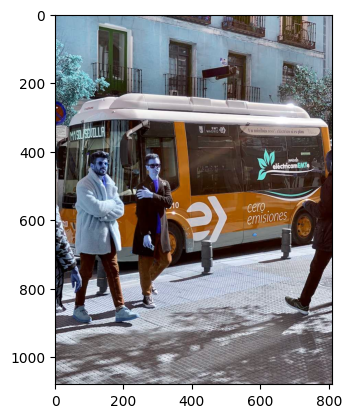

In [12]:
import imutils
import cv2
import matplotlib.pyplot as plt
img_path = str(path / 'tmp_088a7623-da83-4d44-ad99-e2e9736d61af.jpg')
image = cv2.imread(img_path)
resize = imutils.resize(image, height=640)
plt.imshow(image)


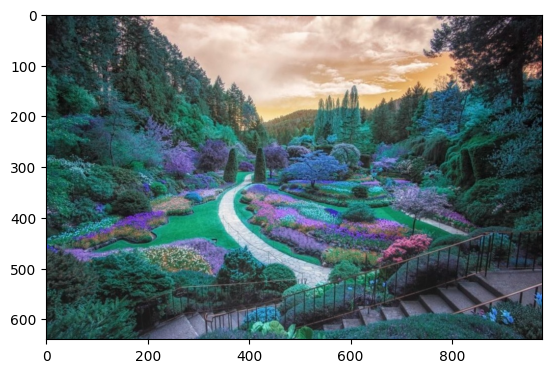

In [19]:

image = cv2.imread("./img/result/result_a2d2f959-8048-4ca5-806a-71e75eba6dae.jpg")

if image is not None:
	plt.imshow(image)
else:
	print(f"Failed to load image at {img_path}")

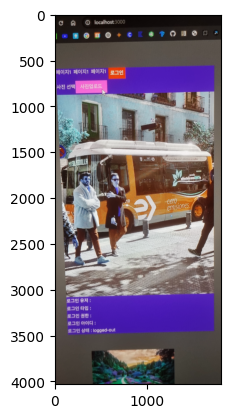

In [3]:
plt.imshow(image)

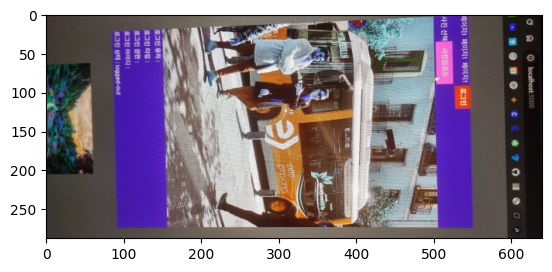

In [7]:
rimg = cv2.rotate(image,0)
resize = imutils.resize(rimg, width=640)
plt.imshow(resize)